# CNN backbone + NN regresion model

Libraries

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import timm
import albumentations as A
from tqdm import tqdm

In [2]:
#timm.list_models()

Parameters

In [3]:
# Path control
path = '../input/petfinder-pawpularity-score/'
img_dir = path + 'train/'
label_path = path + 'train.csv'

# Parameters
random_seed = 17
pin_memory = True
num_workers = os.cpu_count() 
fraction_data = 1 # 1=100%
val_size = 0.2
img_size = 224

#Hiperparameters
NUM_EPOCHS = 8
BATCH_SIZE = 16 # 32
ACCUM_GRAD = 4
LEARNING_RATE = 0.001 #0.00001
MOMENTUM = 0.9
F_OPTIMIZER = optim.SGD
LOSS_FUNCTION = nn.MSELoss()
SCHEDULER_MODE = "triangular2"
EARLY_STOPPING_EPOCHS = 2
MODEL_NAME='tf_efficientnet_b2_ns'

In [4]:
# Bunch of Transformations
transforms_train = A.Compose([
    A.Transpose(p=0.5),
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightness(limit=0.2, p=0.75),
    A.RandomContrast(limit=0.2, p=0.75),
    A.OneOf([
        A.MotionBlur(blur_limit=5),
        A.MedianBlur(blur_limit=5),
        A.GaussianBlur(blur_limit=5),
        A.GaussNoise(var_limit=(5.0, 30.0)),
    ], p=0.7),

    A.OneOf([
        A.OpticalDistortion(distort_limit=1.0),
        A.GridDistortion(num_steps=5, distort_limit=1.),
        A.ElasticTransform(alpha=3),
    ], p=0.7),

    A.CLAHE(clip_limit=4.0, p=0.7),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.85),
    A.Resize(img_size, img_size),
    A.Cutout(max_h_size=int(img_size * 0.375), max_w_size=int(img_size * 0.375), num_holes=1, p=0.7),    
    A.Normalize()
])

transforms_val = A.Compose([
    A.Resize(img_size, img_size),
    A.Normalize()
])

/home/denis/miniconda3/envs/deepsing/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:1744: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/denis/miniconda3/envs/deepsing/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:1770: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/denis/miniconda3/envs/deepsing/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:1896: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(
/home/denis/miniconda3/envs/deepsing/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:688: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(


Setting randomness

In [5]:
def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=random_seed)

Device

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


Define pytorch dataset object

In [7]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, label_dataframe, img_name, label_name, meta_x, transform=None):
        self.img_dir = img_dir
        self.img_label = label_dataframe
        self.transform = transform
        self.img_name = img_name
        self.label_name = label_name
        self.meta_x = meta_x
        
    def __len__(self):
        return len(self.img_label)

    def __getitem__(self, ix):
        meta_x_ix = self.img_label[self.meta_x].iloc[ix]
        meta_x_ix = torch.tensor(meta_x_ix, dtype=torch.float32)

        img_path = self.img_dir + self.img_label[self.img_name][ix] + '.jpg'
        X_ix = plt.imread(img_path)
        if self.transform:
            X_ix = self.transform(image=X_ix)['image']
        X_ix = torch.tensor(X_ix).permute(2, 0, 1).float()

        Y_ix = self.img_label[self.label_name][ix]
        Y_ix = torch.tensor(Y_ix, dtype=torch.float32)

        return (X_ix, meta_x_ix) , Y_ix

Instances Dataset & Dataloader objects

In [8]:
df = pd.read_csv(label_path).sample(frac=fraction_data, random_state=random_seed).sort_index()
df['nPawpularity']=(df['Pawpularity'] - df['Pawpularity'].min()) / (df['Pawpularity'].max() - df['Pawpularity'].min())
df_train, df_val = train_test_split(df, test_size=0.2, random_state=random_seed)
df_train.reset_index(inplace=True)
df_val.reset_index(inplace=True)
df

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,nPawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,0.626263
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,0.414141
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28,0.272727
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15,0.141414
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72,0.717172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9907,ffbfa0383c34dc513c95560d6e1fdb57,0,0,0,1,0,0,0,0,0,0,0,1,15,0.141414
9908,ffcc8532d76436fc79e50eb2e5238e45,0,1,1,1,0,0,0,0,0,0,0,0,70,0.696970
9909,ffdf2e8673a1da6fb80342fa3b119a20,0,1,1,1,0,0,0,0,1,1,0,0,20,0.191919
9910,fff19e2ce11718548fa1c5d039a5192a,0,1,1,1,0,0,0,0,1,0,0,0,20,0.191919


In [9]:
meta_x_columns = [
    'Subject Focus','Eyes','Face','Near','Action','Accessory', 
    'Group', 'Collage','Human','Occlusion','Info','Blur'
    ]

dataset = {
    'train': Dataset(img_dir, df_train, 'Id', 'Pawpularity', meta_x_columns, transform=transforms_train),
    'val'  : Dataset(img_dir, df_val  , 'Id', 'Pawpularity', meta_x_columns, transform=transforms_val)
}

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers, pin_memory=pin_memory),
    'val'  : torch.utils.data.DataLoader(dataset['val']  , batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
}

Sample images (to see augmentations)

(Help function: Inverse of transform : Normalize())

In [10]:
class UnNormalize(object):
    def __init__(self, mean, std, max_pixel_value):
        self.mean = mean
        self.std = std
        self.max_pixel_value = max_pixel_value

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s*self.max_pixel_value).add_(m*self.max_pixel_value)
            # The normalize code -> t.sub_(m*self.max_pixel_value).div_(s*self.max_pixel_value)
        return tensor

unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=1.0)

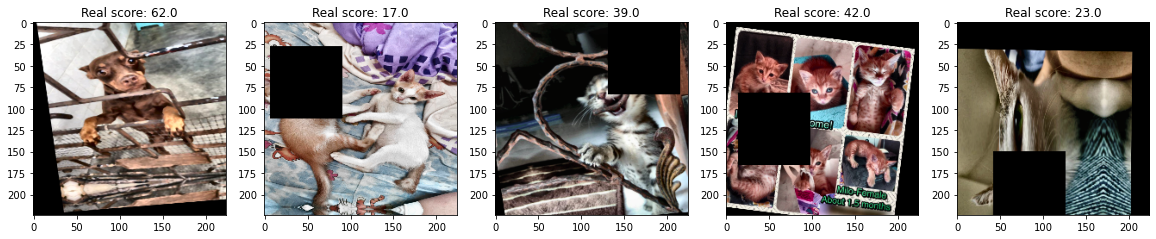

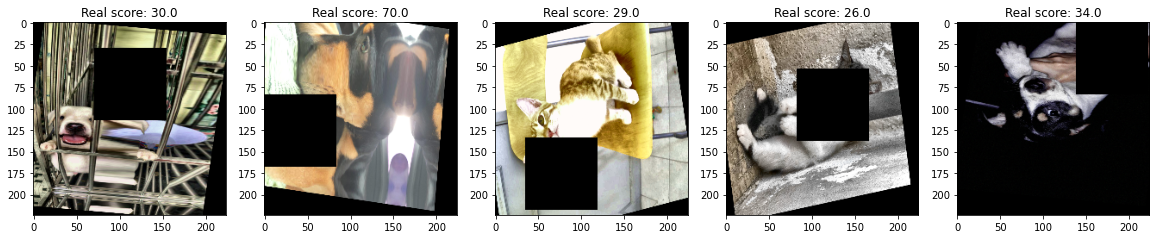

In [11]:
from pylab import rcParams

dataset_show = dataset['train']
rcParams['figure.figsize'] = 20,10
for i in range(2):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = np.random.randint(0, len(dataset_show))
        img, label = dataset_show[idx]
        img = unorm(img[0]) # not necesary to divide by 255 due to using UnNormalize with max_pixel_value=1.0
        axarr[p].imshow(img.permute(1, 2, 0))
        axarr[p].set_title(f'Real score: {label.item()}')
plt.show()

Tailored network based on efficientnet

In [12]:
class BackboneNet(nn.Module):
    def __init__(self, timm_model_name, len_meta_x, out_dim, pretrained=True, freezepretrained=False):
        super().__init__()

        self.efficientmodel = timm.create_model(timm_model_name, pretrained=pretrained)
        n_features = self.efficientmodel.classifier.in_features
        self.efficientmodel.classifier = nn.Identity()
        
        self.metamodel = nn.Sequential(
            nn.Linear(len_meta_x, 512), 
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3), 
            nn.Linear(512, 128), 
            nn.BatchNorm1d(128),
            nn.ReLU()
        )
        n_features += 128
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(n_features, out_dim)

        # freeze weights of efficientnet
        if freezepretrained:
            for param in self.efficientmodel.parameters():
                param.requires_grad = False


    def forward(self, image, meta_x):
        # backbone 1: efficient net
        x1 = self.efficientmodel(image)
        # backbone 2: meta model
        x2 = self.metamodel(meta_x)
        # concatenate backbones
        x = torch.cat((x1, x2), dim=1)
        # head
        x = self.dropout(x)
        x = self.fc(x)
        # drop dimension of size 1 (same as .view(-1)) (if not, broadcasting problems with y ground truth)
        x = x.squeeze()     
        return x

In [13]:
net = BackboneNet(timm_model_name=MODEL_NAME, len_meta_x=12, out_dim=1, pretrained=True, freezepretrained=False)
net.to(device) 

BackboneNet(
  (efficientmodel): EfficientNet(
    (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (act1): SiLU(inplace=True)
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SiLU(inplace=True)
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, t

Count total model trainable parameters

In [14]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(net)

+-------------------------------------------------+------------+
|                     Modules                     | Parameters |
+-------------------------------------------------+------------+
|         efficientmodel.conv_stem.weight         |    864     |
|            efficientmodel.bn1.weight            |     32     |
|             efficientmodel.bn1.bias             |     32     |
|     efficientmodel.blocks.0.0.conv_dw.weight    |    288     |
|       efficientmodel.blocks.0.0.bn1.weight      |     32     |
|        efficientmodel.blocks.0.0.bn1.bias       |     32     |
| efficientmodel.blocks.0.0.se.conv_reduce.weight |    256     |
|  efficientmodel.blocks.0.0.se.conv_reduce.bias  |     8      |
| efficientmodel.blocks.0.0.se.conv_expand.weight |    256     |
|  efficientmodel.blocks.0.0.se.conv_expand.bias  |     32     |
|     efficientmodel.blocks.0.0.conv_pw.weight    |    512     |
|       efficientmodel.blocks.0.0.bn2.weight      |     16     |
|        efficientmodel.b

7776131

Fake and Real Batch examples to net inference

Fake example: random tensors

In [15]:
tensordeprueba = torch.rand(5, 3, 224, 224).to(device)
metadatosdeprueba = torch.rand(5, 12).to(device)
net.eval()
y_hat = net(tensordeprueba, metadatosdeprueba)
y_hat

tensor([-0.0412, -0.0546, -0.0938, -0.0454, -0.0593], device='cuda:0',
       grad_fn=<SqueezeBackward0>)

Real example: Get 1 batch from dataloader['train']

In [16]:
(X_batch, meta_x_batch), y = next(iter(dataloader['train']))
X_batch = X_batch.to(device)
meta_x_batch = meta_x_batch.to(device)
net.eval()
y_hat = net(X_batch, meta_x_batch)
y_hat

tensor([ 0.2615,  0.1041, -0.1257,  0.0599, -0.3450, -0.1392, -0.1898, -0.1421,
         0.2230,  0.1149, -0.0046, -0.2162,  0.1736, -0.0086, -0.0095,  0.4005],
       device='cuda:0', grad_fn=<SqueezeBackward0>)

Train the model

In [17]:
'''optimizer1 = optim.SGD(net.parameters(), lr=0.1)
scheduler1 = optim.lr_scheduler.StepLR(optimizer1, step_size=5, gamma=0.5)
scheduler1 = torch.optim.lr_scheduler.CyclicLR(optimizer1, base_lr=LEARNING_RATE/100, max_lr=LEARNING_RATE ,step_size_up=10,mode=SCHEDULER_MODE)

for i in range(50):
    lr = scheduler1.get_last_lr()[0]
    lr1 = optimizer1.param_groups[0]["lr"]
    print(f"{i}, {lr:.6f}, {lr1:.6f}")
    scheduler1.step()'''

'optimizer1 = optim.SGD(net.parameters(), lr=0.1)\nscheduler1 = optim.lr_scheduler.StepLR(optimizer1, step_size=5, gamma=0.5)\nscheduler1 = torch.optim.lr_scheduler.CyclicLR(optimizer1, base_lr=LEARNING_RATE/100, max_lr=LEARNING_RATE ,step_size_up=10,mode=SCHEDULER_MODE)\n\nfor i in range(50):\n    lr = scheduler1.get_last_lr()[0]\n    lr1 = optimizer1.param_groups[0]["lr"]\n    print(f"{i}, {lr:.6f}, {lr1:.6f}")\n    scheduler1.step()'

In [18]:
def fit(model, dataloader, epochs=NUM_EPOCHS, checkpoint=None):

    # define number of accumulation steps, mixed precision training, loss function (criterion), optimizer, and scheduler
    accum_grad = ACCUM_GRAD
    scaler = torch.cuda.amp.GradScaler() # APEX AMP for mixed precision training
    criterion = LOSS_FUNCTION
    optimizer = F_OPTIMIZER(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)    
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=LEARNING_RATE/100, max_lr=LEARNING_RATE, step_size_up=5, mode=SCHEDULER_MODE)

    # internal parameters for training loop
    epoch_ini = 1
    epochs_no_improve = 0    
    best_val_loss = 999999999
    min_improvement = 1

    # load checkpoint if provided
    if checkpoint is not None:
        print("Loading checkpoint...", flush=True)
        checkpoint = torch.load(checkpoint)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        epoch_ini = checkpoint['epoch']+1
        best_val_loss = checkpoint['val_loss']
        print(f"Checkpoint loaded. Resuming in epoch: {epoch_ini} and Best validation loss: {best_val_loss: .5f}", flush=True)

    # zero the parameter gradients
    model.zero_grad()
    # training loop
    for epoch in range(epoch_ini, epoch_ini+epochs):
        model.train()
        train_loss = []
        train_lr = []
        bar = tqdm(dataloader['train'])
        for batch_idx, batch in enumerate(bar):
            # get the inputs; data is a list of [inputs, labels]
            (X, X_meta), y = batch
            X, X_meta, y = X.to(device), X_meta.to(device), y.to(device)
  
            # forward + backward + optimize (with APEX: automatic mixed precision)
            with torch.cuda.amp.autocast(): 
                y_hat = model(X, X_meta)
                loss = criterion(y_hat, y)

            # normalize loss to account for batch accumulation
            loss = loss / accum_grad 

            # backward pass (with APEX: automatic mixed precision)
            #loss.backward()
            scaler.scale(loss).backward()   

            # weights update with gradient accumulation (with APEX: automatic mixed precision))
            if ((batch_idx + 1) % accum_grad == 0) or (batch_idx + 1 == len(dataloader)):
                scaler.step(optimizer)
                scaler.update()
                model.zero_grad()

                # update learning rate (and ¿momentum?)
                scheduler.step()
                lr_step = scheduler.get_last_lr()[0]
                train_lr.append(lr_step)            

                # save loss
                train_loss.append(loss.item())

                # verbose within the bar
                bar.set_description(f"loss {np.mean(train_loss):.5f} rmse {np.mean(train_loss)**0.5:.5f} lr {lr_step:.6f}")


        bar = tqdm(dataloader['val'])
        val_loss = []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                # get the inputs; data is a list of [inputs, labels]
                (X, X_meta), y = batch
                X, X_meta, y = X.to(device), X_meta.to(device), y.to(device)

                # forward
                y_hat = model(X, X_meta)
                loss = criterion(y_hat, y)

                # save loss
                val_loss.append(loss.item())

                # verbose within the bar
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_rmse {np.mean(val_loss)**0.5:.5f}")

        print(f"::::Epoch {epoch}/{epoch_ini+epochs-1} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} rmse {np.mean(train_loss)**0.5:.5f} val_rmse {np.mean(val_loss)**0.5:.5f}::::", flush=True)

        #save the model if the validation loss is the best we've seen so far / early stopping
        if np.mean(val_loss) < best_val_loss - min_improvement:
            print(f"Validation loss improved from {best_val_loss:.5f} to {np.mean(val_loss):.5f}. Saving model...", flush=True)
            epochs_no_improve = 0
            best_val_loss = np.mean(val_loss)
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'loss': np.mean(train_loss),
                'val_loss': np.mean(val_loss),
                'rmse': np.mean(train_loss)**0.5,
                'val_rmse': np.mean(val_loss)**0.5,           
                'train_lr': train_lr
            }, '../models/_ckpt.pt')
            print("Model saved.", flush=True)
        else :
            epochs_no_improve += 1
            print(f"Validation loss did not improve", flush=True)
            if epochs_no_improve >= EARLY_STOPPING_EPOCHS:
                print(f"Validation loss did not improve significantly (-{min_improvement}) for {epochs_no_improve} epochs. Stopping training.", flush=True)
                break
 

In [27]:
fit(net, dataloader, epochs=6)

  0%|          | 0/496 [00:00<?, ?it/s][W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
  0%|          | 1/496 [00:05<49:08,  5.96s/it]/home/denis/miniconda3/envs/deepsing/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_schedu

::::Epoch 1/6 loss 148.17820 val_loss 386.97962 rmse 12.17285 val_rmse 19.67180::::
Validation loss improved from 999999999.00000 to 386.97962. Saving model...


Model saved.


  0%|          | 0/496 [00:00<?, ?it/s][W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
loss 103.05184 rmse 10.15145 lr 0.000010: 100%|██████████| 496/496 [08:58<00:00,  2.98it/s][W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpoo

::::Epoch 2/6 loss 103.05184 val_loss 373.04205 rmse 10.15145 val_rmse 19.31430::::
Validation loss improved from 386.97962 to 373.04205. Saving model...


Model saved.


  0%|          | 0/496 [00:00<?, ?it/s][W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
  0%|          | 0/124 [00:00<?, ?it/s][W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2

::::Epoch 3/6 loss 101.01099 val_loss 367.15853 rmse 10.05042 val_rmse 19.16138::::
Validation loss improved from 373.04205 to 367.15853. Saving model...


Model saved.


  0%|          | 0/496 [00:00<?, ?it/s][W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
loss 93.79959 rmse 9.68502 lr 0.000010:  23%|██▎       | 113/496 [02:05<07:05,  1.11s/it][W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)

KeyboardInterrupt: 

In [19]:
fit(net, dataloader, epochs=6, checkpoint='../models/_ckpt.pt')

Loading checkpoint...
Checkpoint loaded. Resuming in epoch: 4 and Best validation loss:  367.15853


  0%|          | 0/496 [00:00<?, ?it/s][W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
  0%|          | 0/124 [00:00<?, ?it/s][W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2

::::Epoch 4/9 loss 74.12388 val_loss 379.39831 rmse 8.60952 val_rmse 19.47815::::
Validation loss did not improve



  0%|          | 0/496 [00:00<?, ?it/s][W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
loss 80.11934 rmse 8.95094 lr 0.000010: 100%|██████████| 496/496 [09:15<00:00,  3.45it/s][W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool

::::Epoch 5/9 loss 80.11934 val_loss 374.91155 rmse 8.95094 val_rmse 19.36263::::
Validation loss did not improve
Validation loss did not improve significantly (-1) for 2 epochs. Stopping training.


Save the model

In [ ]:
#torch.save(net.state_dict(), '../models/backbone_effb1_bs32ga4_lr00001_m09.pt')